In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import *
from commando.utilities import predict_nn
import matplotlib.pyplot as plt
from mmd_wrapper import mmd_combine
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

2022-09-26 22:32:25.021177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-26 22:32:25.021230: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
np.random.seed(42)

In [4]:
dataset_name = 'scMNC-Visual'
modality_names = ['Gene Expression', 'Electrophysiology']
data1 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/geneExp_filtered.csv")
data2 = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/efeature_filtered.csv")
sample_names1 = data1.columns[1:]
sample_names2 = np.array(data2)[:, 0]
feature_names1 = data1.iloc[:,0]
feature_names2 = data2.columns[1:]
assert (sample_names1 == sample_names2).all()
data1 = np.transpose(np.array(data1)[:, 1:])
data2 = np.array(data2)[:, 3:]
meta = pd.read_csv("../data/scMNC/mouse_visual_cortex/data/20200711_patchseq_metadata_mouse.csv")[['transcriptomics_sample_id', 't_type']]
meta = np.array(meta)
meta_idx = [np.argwhere(meta[:, 0] == sample_names1[i])[0][0] for i in range(sample_names1.shape[0])]
type1 = type2 = np.array([x.split(' ')[0] for x in meta[meta_idx, 1]])

# Sampling
# split = 1000 # data1.shape[0]
# data_col_idx = np.random.choice(range(data1.shape[0]), split, replace=False)
# data1, data2, type1, type2 = (x[data_col_idx] for x in (data1, data2, type1, type2))

# Labels
labels = [type1, type2]
features = [list(feature_names1), list(feature_names2)]

# Utility
positivize = lambda X: [x + x.min() for x in X]
minmax = lambda X: [(x + x.min()) for x in X]

# Preprocessing
data1 = preprocessing.scale(data1, axis=0)
data2 = preprocessing.scale(data2, axis=0)
data1[np.isnan(data1)] = 0  # Replace NaN with average
data2[np.isnan(data2)] = 0
data1 = preprocessing.MinMaxScaler().fit_transform(data1)
data2 = preprocessing.MinMaxScaler().fit_transform(data2)
dataset = [data1, data2]

# Replace NULL feature names
for i in range(len(features)):
    if features[i] is None:
        features[i] = [f'Feature {i}' for i in range(dataset[i].shape[1])]

In [5]:
# Train-Test Imputation
train_size = int(.8 * len(data1))
train_idx = np.random.choice(range(len(data1)), train_size)
test_idx = np.array(list(set(range(len(data1))) - set(train_idx)))

In [6]:
# Reduced Priors
full_priors = np.eye(len(dataset[0]))

random_idx = np.random.choice(range(len(dataset[0])), int(.5 * len(dataset[0])), replace=False)
priors = np.zeros(len(dataset[0]))
priors[random_idx] = 1
half_priors = np.diag(priors)

none_priors = np.zeros((len(dataset[0]), len(dataset[0])))

# Vars
reduced_dim = 32
batch_size = 256
pca_dim = [256, None]
dist_method = 'euclidean'

# ComManDo

In [76]:
# Integration
kwargs = {
    'output_dim': reduced_dim,
    'epoch_DNN': 2500,
    'log_DNN': 500,
    'use_early_stop': False,
    'batch_size': batch_size,
    'pca_dim': pca_dim,
    'dist_method': dist_method,
    'loss_weights': [0,10,1,1],
}
fromChar = [' ', '),', '(', ')', ',', '\'', '[', ']']
toChar = ['', '--', '', '', '-', '', '(', ')']
kwargs_str = str(sorted(kwargs.items()))[1:-1]
for f, t in zip(fromChar, toChar):
    kwargs_str = kwargs_str.replace(f, t)
hash_str = '---'.join([dataset_name, '-'.join([str(s) for s in dataset[0].shape]), '-'.join([str(s) for s in dataset[1].shape]), kwargs_str])

In [52]:
# Integration
cm = ComManDo(**kwargs)  # , match_result=cm.match_result, debug=True)
model_str = 'saved_models/cm---' + hash_str + '.h5'
try:
    # raise FileNotFoundError()
    cm.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
except FileNotFoundError:
    cm_data = cm.fit_transform(dataset=dataset)
    cm.save_model(model_str)
cm_data = cm.transform(dataset=dataset)

use random seed: 666
Shape of Raw data
Dataset 0: (1000, 1302)
Dataset 1: (1000, 39)
---------------------------------
Train coupled autoencoders
KL: 0.0000  Rec: 18.3705  CosSim: 4.5328  F: 4.7496
KL: 0.0000  Rec: 15.8062  CosSim: 3.3466  F: 1.1826
KL: 0.0000  Rec: 14.8643  CosSim: 2.4839  F: 0.7159
KL: 0.0000  Rec: 13.0321  CosSim: 2.0008  F: 0.5738
epoch:[500/2500]: loss:14.653728
KL: 0.0000  Rec: 12.5504  CosSim: 1.6837  F: 0.2499
KL: 0.0000  Rec: 12.3327  CosSim: 1.4497  F: 0.2833
KL: 0.0000  Rec: 11.4820  CosSim: 1.3092  F: 0.1409
KL: 0.0000  Rec: 10.6747  CosSim: 1.1559  F: 0.1243
KL: 0.0000  Rec: 10.8905  CosSim: 1.0277  F: 0.1827
epoch:[1000/2500]: loss:11.596524
KL: 0.0000  Rec: 10.9106  CosSim: 0.9101  F: 0.1066
KL: 0.0000  Rec: 10.3160  CosSim: 0.8358  F: 0.1096
KL: 0.0000  Rec: 10.1886  CosSim: 0.7751  F: 0.1109
KL: 0.0000  Rec: 10.1922  CosSim: 0.6899  F: 0.0681
KL: 0.0000  Rec: 10.0655  CosSim: 0.6340  F: 0.0980
epoch:[1500/2500]: loss:10.690121
KL: 0.0000  Rec: 9.7720  

In [77]:
# Imputation
cm_im = ComManDo(**kwargs)
model_str = 'saved_models/cm_im---' + hash_str + '.h5'
try:
    # raise FileNotFoundError()
    cm_im.load_model(model_str)
    print(f'Loaded model \'{model_str}\'')
except FileNotFoundError:
    cm_im.fit_transform(dataset=[data1[train_idx], data2[train_idx]])
    cm_im.save_model(model_str)
cm_imputed = [cm_im.modal_predict(dataset[i][test_idx], i) for i in range(1, -1, -1)]

use random seed: 666
Shape of Raw data
Dataset 0: (800, 1302)
Dataset 1: (800, 39)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[500/2000] err:0.3362 alpha:0.0626
epoch:[1000/2000] err:0.4877 alpha:0.0975
epoch:[1500/2000] err:0.5468 alpha:0.1231
epoch:[2000/2000] err:0.5527 alpha:0.1408
Finished Matching!
---------------------------------
Train coupled autoencoders
epoch:[500/2500]: loss:12.478168
epoch:[1000/2500]: loss:10.693462
epoch:[1500/2500]: loss:9.917604
epoch:[2000/2500]: loss:9.708796
epoch:[2500/2500]: loss:9.304897
Finished Mapping!
---------------------------------
ComManDo Done!
Distance: 0.5561828389763832
Correspondence: 53.311569579993375
Mapping: 199.06904664600734
Total: 252.9367990649771



# Comparison Methods

In [10]:
integrated_data = [cm_data]
integrated_names = ['JAMIE']
colors = ['blue']

In [11]:
# NLMA
nlma_data, _ = mmd_combine(*dataset, method='maninetcluster', alignment='nonlinear manifold aln', num_dims=reduced_dim)
integrated_data.append(nlma_data)
integrated_names.append('NLMA')
colors.append('red')

In [12]:
# LMA
lma_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='linear manifold', num_dims=reduced_dim)
integrated_data.append(lma_data)
integrated_names.append('LMA')
colors.append('orange')

In [13]:
# CCA
cca_data, _, _ = mmd_combine(*dataset, method='maninetcluster', alignment='cca', num_dims=reduced_dim)
integrated_data.append(cca_data)
integrated_names.append('CCA')
colors.append('m')

In [78]:
# # MMD-MA
# from sklearn.metrics import pairwise_distances
# mmd_ma_data, _, _ = mmd_combine(pairwise_distances(dataset[0]), pairwise_distances(dataset[1]), method='mmd_ma', p=reduced_dim)
# integrated_data.append(mmd_ma_data)
# integrated_names.append('MMD-MA')
# colors.append('yellow')

In [15]:
# UnionCom
uc_data, _, _ = mmd_combine(*dataset, method='unioncom', output_dim=reduced_dim)
integrated_data.append(uc_data)
integrated_names.append('Unioncom')
colors.append('green')

use random seed: 666
Shape of Raw data
Dataset 0: (1000, 1302)
Dataset 1: (1000, 39)
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
use device: cpu
epoch:[100/2000] err:9.8536 alpha:2.0439
epoch:[200/2000] err:1.3202 alpha:0.2738
epoch:[300/2000] err:0.1769 alpha:0.0367
epoch:[400/2000] err:0.1131 alpha:0.0235
epoch:[500/2000] err:0.1506 alpha:0.0313
epoch:[600/2000] err:0.1863 alpha:0.0389
epoch:[700/2000] err:0.2210 alpha:0.0462
epoch:[800/2000] err:0.2542 alpha:0.0534
epoch:[900/2000] err:0.2857 alpha:0.0603
epoch:[1000/2000] err:0.3152 alpha:0.0670
epoch:[1100/2000] err:0.3424 alpha:0.0733
epoch:[1200/2000] err:0.3672 alpha:0.0793
epoch:[1300/2000] err:0.3894 alpha:0.0849
epoch:[1400/2000] err:0.4090 alpha:0.0902
epoch:[1500/2000] err:0.4261 alpha:0.0951
epoch:[1600/2000] err:0.4405 alpha:0.0997
epoch:[1700/2000] err:0.4524 alpha:0.1040
epoch:[1800/2000] err:0.4620 alpha:0.1080
epoch:[1900/2000] err:0.4695 alpha:0.1117
epoch:[2000/2000] err:0.

In [97]:
# Imputation
if False:
    imputation_name = 'Babel'
else:
    imputation_name = 'Dual Autoencoder'
    nn_imputed = [predict_nn(torch.tensor(dataset[i][train_idx]).float(), torch.tensor(dataset[(i+1)%2][train_idx]).float(), torch.tensor(dataset[i][test_idx]).float()) for i in range(1, -1, -1)]
imputed_data = [cm_imputed, nn_imputed][::-1]
imputed_names = ['JAMIE', imputation_name][::-1]

200/200 [|||||||||||||||||||||||||]: - 25/25 (++++++++++) - Loss: 0.0261
Done!
200/200 [|||||||||||||||||||||||||]: - 25/25 (++++++++++) - Loss: 0.0258
Done!


# Visualization

In [98]:
imputed_data = [cm_imputed, nn_imputed][::-1]
integrated_data[0] = cm_data

In [54]:
style='white'
sns.set(style=style)
plt.rcParams.update({'font.weight': 'normal',
                     'font.size': 18,
                     'axes.titlesize': 'large',
                     'axes.labelsize': 'large',
                     'xtick.labelsize': 'small',
                     'ytick.labelsize': 'small'})

In [55]:
%%capture
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

algorithm_elements = [Line2D([0], [0], color=c, lw=5, label=n) for n, c in zip(integrated_names, colors)]
label_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=plt.rcParams['axes.prop_cycle'].by_key()['color'][i], label=l, markersize=10) for i, l in enumerate(np.unique(labels))]

# https://stackoverflow.com/a/47749903
fig, ax = plt.subplots()
legend = ax.legend(handles=label_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('./output_figures/' + dataset_name + '-labelLegend.png', bbox_inches=bbox, dpi=300)

fig, ax = plt.subplots()
legend = ax.legend(handles=algorithm_elements, loc='center', frameon=False)
legend.figure.canvas.draw()
bbox = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('./output_figures/' + dataset_name + '-algorithmLegend.png', bbox_inches=bbox, dpi=300)

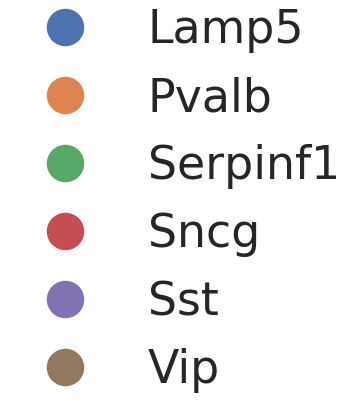

In [70]:
from IPython.display import Image
display(Image(filename='./output_figures/' + dataset_name + '-labelLegend.png', width=100))

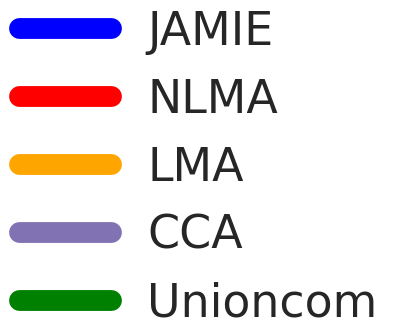

In [71]:
from IPython.display import Image
display(Image(filename='./output_figures/' + dataset_name + '-algorithmLegend.png', width=100))

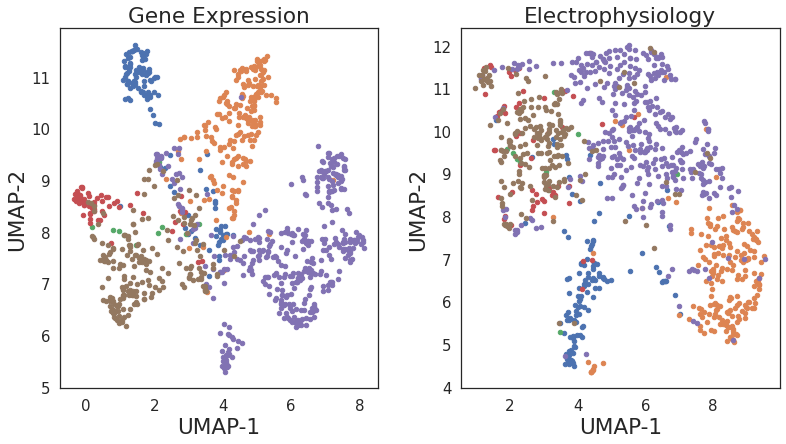

In [56]:
fig = plt.figure(figsize=(10, 5))
plot_regular(dataset, labels, modality_names)
plt.tight_layout()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Data.png', dpi=300)

In [ ]:
# fig = plt.figure(figsize=(10, 5))
# plot_integrated(cm_data, labels, ['JAMIE - ' + mn for mn in modality_names])
# plt.tight_layout()
# plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
# plt.savefig('./output_figures/' + dataset_name + '-JAMIE.png', dpi=300)

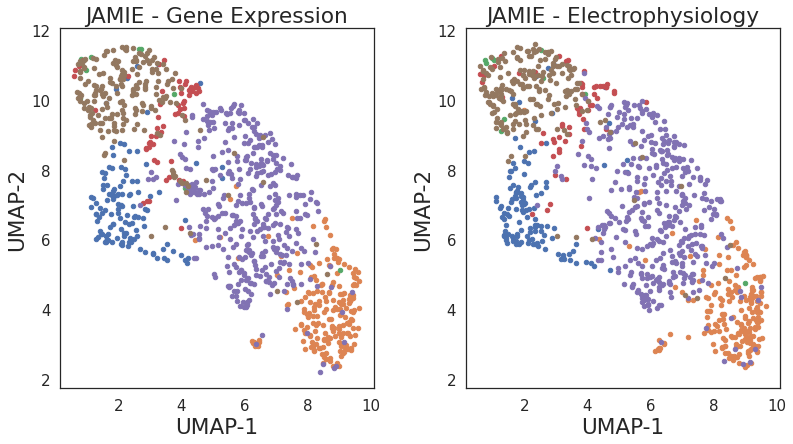

None

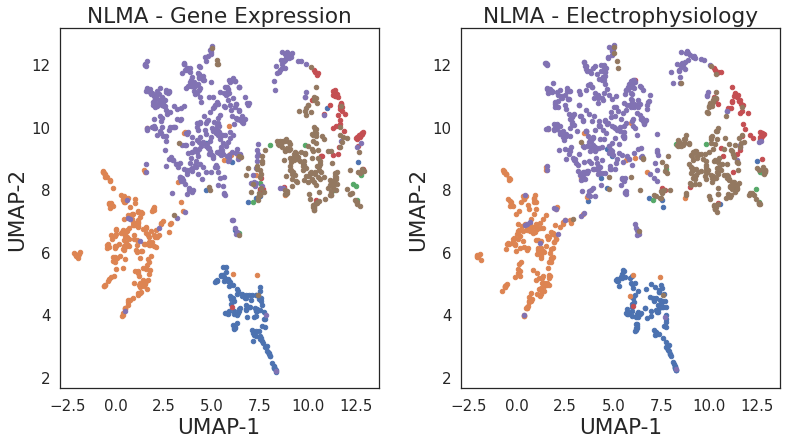

None

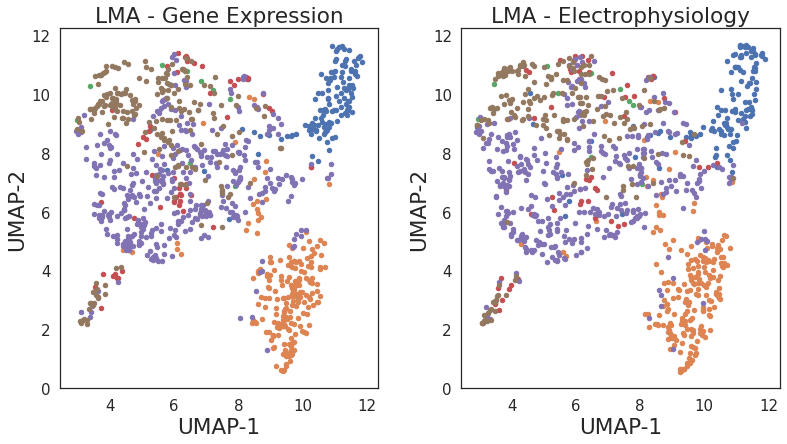

None

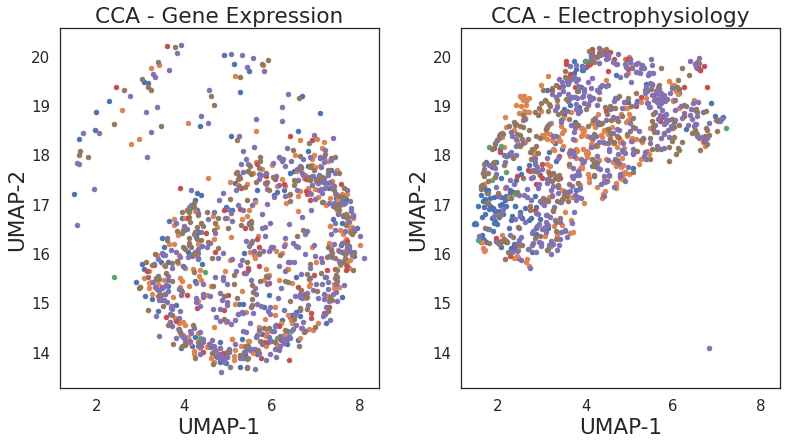

None

KeyboardInterrupt: 

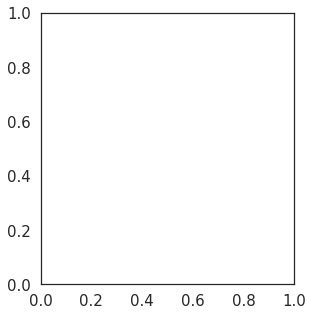

In [102]:
for d, n in zip(integrated_data, integrated_names):
    fig = plt.figure(figsize=(10, 5))
    plot_integrated(d, labels, [f'{n} - ' + mn for mn in modality_names], legend=False)
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
    plt.savefig('./output_figures/' + dataset_name + f'-{n}.png', dpi=300)
    plt.show()

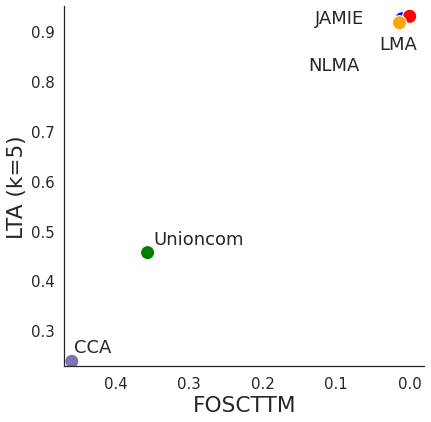

In [59]:
plt.figure(figsize=(5, 5))
plot_accuracy_graph(integrated_data, labels, integrated_names, colors=colors)
sns.despine()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Acc.png', dpi=300)

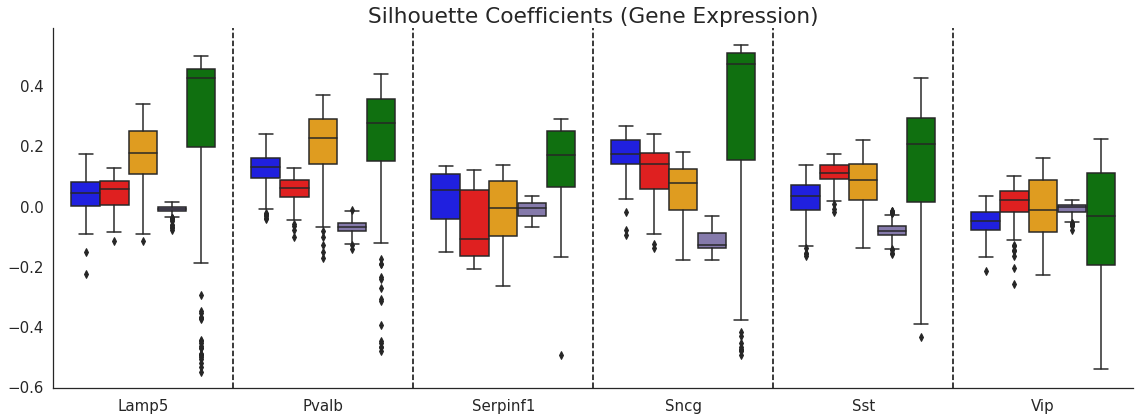

In [60]:
plt.figure(figsize=(15, 5))
plot_silhouette([[d[0]] for d in integrated_data], [labels[0]], integrated_names, modality_names[:1], colors=colors)
sns.despine()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Sil.png', dpi=300)

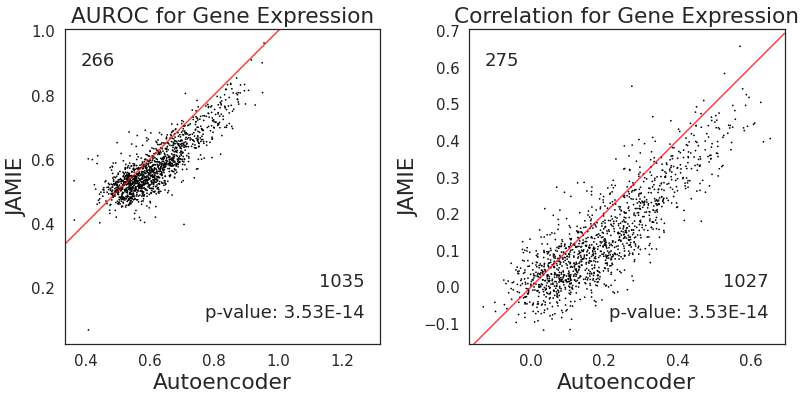

In [99]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=0, names=imputed_names)
plt.tight_layout()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Imp1.png', dpi=300)

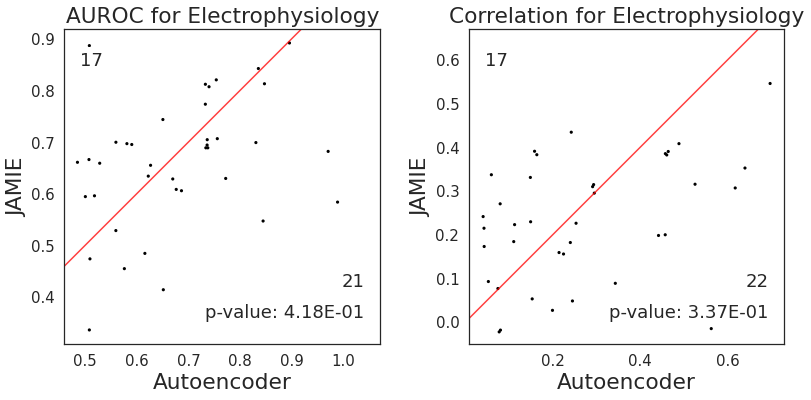

In [100]:
plt.figure(figsize=(10, 5))
plot_auroc_correlation(imputed_data, [data1[test_idx], data2[test_idx]], modality_names, index=1, names=imputed_names)
plt.tight_layout()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Imp2.png', dpi=300)

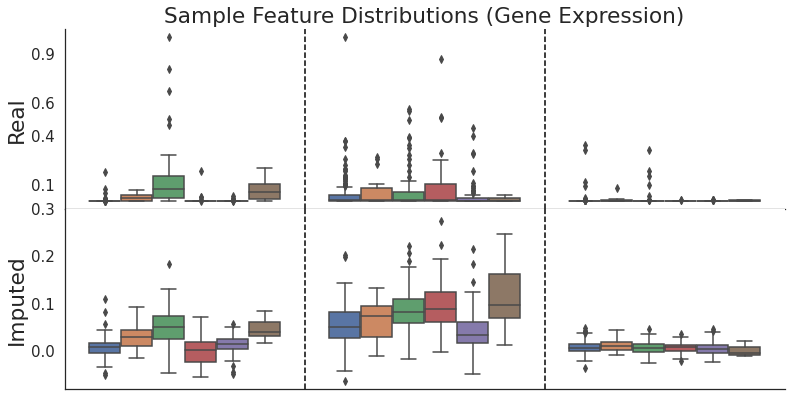

In [82]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Dist1.png', dpi=300)

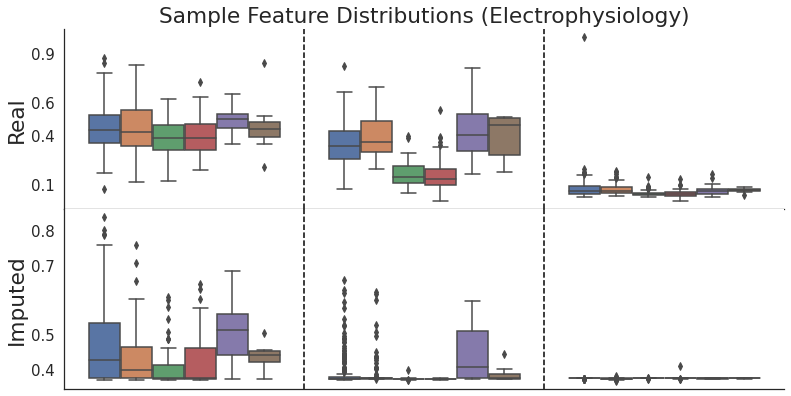

In [83]:
plt.figure(figsize=(10, 5))
plot_distribution_alone([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.savefig('./output_figures/' + dataset_name + '-Dist2.png', dpi=300)

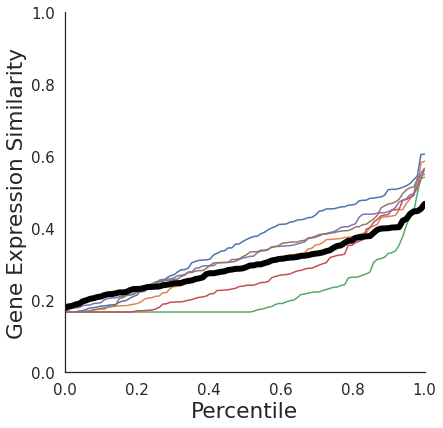

In [84]:
plt.figure(figsize=(10, 5))
plot_distribution_similarity([dataset[0][test_idx], cm_imputed[0]], 2*[labels[0][test_idx]], title=modality_names[0], fnames=2*[features[0]])
sns.despine()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Sim1.png', dpi=300)

invalid value encountered in true_divide


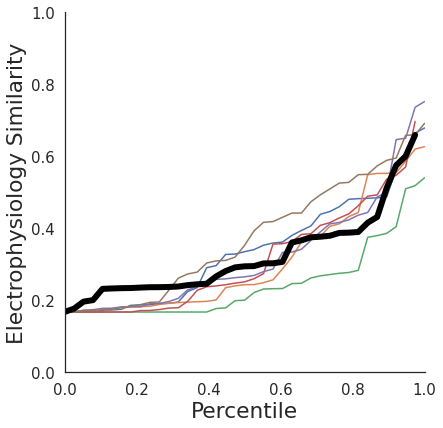

In [85]:
plt.figure(figsize=(10, 5))
plot_distribution_similarity([dataset[1][test_idx], cm_imputed[1]], 2*[labels[1][test_idx]], title=modality_names[1], fnames=2*[features[1]])
sns.despine()
plt.gcf().subplots_adjust(left=0, bottom=0, right=1, top=1)
plt.savefig('./output_figures/' + dataset_name + '-Sim2.png', dpi=300)

# Explanation

In [30]:
# RNA (Place) -> Ephys
# Prickle1 (1) -> peak_t_long_square

In [32]:
mod0, mod1 = 0, 1

In [83]:
from commando.utilities import sort_by_interest

order, interest = sort_by_interest([cm_imputed[mod1], dataset[mod1][test_idx]], limit=10)
order_str = ', '.join([str(n) for n in order[:10]])
order_names_str = ', '.join(features[mod1][order[:10]])
print(f'Top performing features for SHAP:\n{order_names_str}\n{order_str}')
print()
interest_str = ', '.join([str(n) for n in interest[:10]])
interest_names_str = ', '.join(features[mod1][interest[:10]])
print(f'Top interesting features for SHAP:\n{interest_names_str}\n{interest_str}')

invalid value encountered in true_divide
An input array is constant; the correlation coefficient is not defined.


Top performing features for SHAP: 18404, 14412, 31651, 26558, 32408, 22405, 3753, 16231, 32984, 10479
Top interesting features for SHAP: 18404, 9082, 28141, 16220, 27529, 20355, 18578, 11797, 4857, 14345


In [ ]:
import shap

# Subset for runtime
use_subsetting = True
subset_idx = np.random.choice(dataset[mod0].shape[1], 100, replace=False)
background = np.mean(dataset[mod0], axis=0).reshape((1, -1))
def take_subset(x, do=use_subsetting):
    if not do:
        return x
    if len(x.shape) == 1:
        return x[subset_idx]
    return x[:, subset_idx]
def reverse_subset(x, do=use_subsetting):
    if not do:
        return x
    new_vec = np.concatenate(x.shape[0] * [background], axis=0)
    new_vec[:, subset_idx] = x
    return new_vec

target_feature = interest[0]
current_cm = cm_im
model = lambda x: current_cm.modal_predict(reverse_subset(x), mod0)[:, target_feature]
data = dataset[mod0]
back = background
feature_names = features[mod0]
output_names = features[mod1][target_feature]

# Apply subsetting
data = take_subset(data)
back = take_subset(back)
feature_names = list(take_subset(np.array(feature_names)))

# Explainer
explainer = shap.Explainer(model, back, feature_names=feature_names, output_names=output_names)
shap_values = explainer(data, max_evals=2*data.shape[1]+1)

Permutation explainer:  84%|████████████████████████████████▊      | 841/1000 [05:14<01:00,  2.61it/s]

In [ ]:
display = 20
print(f'Target {modality_names[mod1]} Feature: {output_names}')
for n in [output_names]:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')
importance = np.array(shap_values.feature_names)[np.argsort(shap_values.abs.mean(0).values)][::-1][:display]
imp_str = ', '.join(importance)
print(f'Important {modality_names[mod0]} Features: {imp_str}')
for n in importance:
    print(f'https://www.genecards.org/cgi-bin/carddisp.pl?gene={n}')

In [ ]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.summary_plot(shap_values, data, plot_type='violin', max_display=display, plot_size=(9.2, 5), show=False)
plt.savefig('./output_figures/' + dataset_name + '-Summary.png');

In [ ]:
shap.plots.heatmap(shap_values, max_display=display, show=False)
plt.gca().set_xlabel('Samples')
plt.savefig('./output_figures/' + dataset_name + '-Heat.png');

In [ ]:
plt.figure(figsize=(10, 5))
ax = plt.gcf().add_subplot(1, 1, 1)
shap.dependence_plot(np.argsort(np.abs(shap_values.values).mean(0))[::-1][0], shap_values.values, data, ax=ax, show=False)
plt.savefig('./output_figures/' + dataset_name + '-Dep1.png');

## Interactive

In [ ]:
# # Kernel Explainer
# kexplainer = shap.KernelExplainer(model, shap.kmeans(data, 10), feature_names=feature_names, output_names=output_names)
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter('ignore')
#     kshap_values = kexplainer.shap_values(data, nsamples=100)

In [ ]:
# shap.force_plot(kexplainer.expected_value, kshap_values[0, :], data[0, :], matplotlib=True, show=False)
# plt.savefig('./output_figures/' + dataset_name + '-Force.png', bbox_inches='tight');

In [ ]:
# shap.initjs()
# shap.force_plot(kexplainer.expected_value, kshap_values, data)